# Learning Equality Curriculum Reccomendations - EDA

References

- [1] Competition homepage, https://www.kaggle.com/competitions/learning-equality-curriculum-recommendations/overview
- [2] Competition tips notebook, https://www.kaggle.com/code/jamiealexandre/tips-and-recommendations-from-hosts/notebook

### Setup

In [5]:
# Imports and magic commands
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pathlib import Path
from IPython.display import display, Markdown

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Global settings
np.random.seed(13)
mpl.rcParams['figure.figsize'] = (12, 8)
load_data_flag = 1

# Set IO directories
HOME_DIR = Path(r'/kaggle')
INPUT_DIR = HOME_DIR/Path(r'input/learning-equality-curriculum-recommendations')
CACHE_DIR = HOME_DIR/Path(r'input/lecr-cache')
OUTPUT_DIR = HOME_DIR/Path(r'working/learning-equality-curriculum-recommendations')
TEMP_DIR = HOME_DIR/Path(r'tmp')

# Set Kaggle mode
DEVMODE = os.getenv("KAGGLE_MODE") == "DEV"
print(f"DEV MODE: {DEVMODE}")
EPOCHS = 2 if DEVMODE else 30

DEV MODE: True


In [7]:
# Load competition data
if load_data_flag:
    topics_df = pd.read_csv(INPUT_DIR/'topics.csv').set_index('id').fillna({'title': '', 'description': ''})
    topics_df.name = 'topics'
    content_df = pd.read_csv(INPUT_DIR/'content.csv').set_index('id').fillna('')
    content_df.name = 'content'
    correlations_df = pd.read_csv(INPUT_DIR/'correlations.csv').set_index('topic_id')
    correlations_df.name = 'correlations'
    correlations_df.content_ids = correlations_df.content_ids.str.split(' ')
    sample_submission_df = pd.read_csv(INPUT_DIR/'sample_submission.csv')
    sample_submission_df.name = 'sample_submission'

## Exploration

### Overview

In [ ]:
# Get overview of data (shape, head, NaN counts, preview)
def print_basic_info(df):
    print(f'--- {df.name} ({df.shape[0]} rows x {df.shape[1]} columns) ---')    
    # For each column, get name, dtype and NaN count, and print as table
    df_info = pd.DataFrame({'column': df.columns, 'dtype': df.dtypes, 'NaN count': df.isna().sum()}).reset_index(drop=True)
    print(df_info)
    display(df)
    
[print_basic_info(df) for df in [topics_df, content_df, correlations_df, sample_submission_df]]

In [9]:
# Get root topic ids (topics with NaN parent) and respective channel ids, and check that they match
root_topics = topics_df.loc[topics_df.parent.isnull(), 'channel']
assert set(topics_df['channel'].unique()) == set(root_topics), 'Raw unique channels and root topic channels do not match'
assert len(set(root_topics)) == len(root_topics), 'Duplicate channel ids found in root topics'

Training data:
- 80k topics
  - partitioned into 171 channels / topic trees
  - 60k of which have associated content / correlations
  - each root topic (topic with NaN parent) matches a unique channel id
- 150k content items
  - 1.2b possible topic-content correlations
  - 280k actual topic-content correlations

In [10]:
# Helper functions and classes for data traversal from competition tips notebook, edited from Ref. [2]

def print_markdown(md):
    display(Markdown(md))

class Topic:
    def __init__(self, topic_id):
        self.id = topic_id

    @property
    def parent(self):
        parent_id = topics_df.loc[self.id].parent
        if pd.isna(parent_id):
            return None
        else:
            return Topic(parent_id)

    @property
    def ancestors(self):
        ancestors = []
        parent = self.parent
        while parent is not None:
            ancestors.append(parent)
            parent = parent.parent
        return ancestors

    @property
    def siblings(self):
        if not self.parent:
            return []
        else:
            return [topic for topic in self.parent.children if topic != self]

    @property
    def content(self):
        if self.id in correlations_df.index:
            return [ContentItem(content_id) for content_id in correlations_df.loc[self.id].content_ids]
        else:
            return tuple([]) if self.has_content else []

    def get_breadcrumbs(self, separator=" >> ", include_self=True, include_root=True):
        ancestors = self.ancestors
        if include_self:
            ancestors = [self] + ancestors
        if not include_root:
            ancestors = ancestors[:-1]
        return separator.join(reversed([a.title for a in ancestors]))

    @property
    def children(self):
        return [Topic(child_id) for child_id in topics_df[topics_df.parent == self.id].index]

    def subtree_markdown(self, depth=0):
        markdown = "  " * depth + "- " + self.title + "\n"
        for child in self.children:
            markdown += child.subtree_markdown(depth=depth + 1)
        for content in self.content:
            markdown += ("  " * (depth + 1) + "- " + "[" + content.kind.title() + "] " + content.title) + "\n"
        return markdown

    def __eq__(self, other):
        if not isinstance(other, Topic):
            return False
        return self.id == other.id

    def __getattr__(self, name):
        return topics_df.loc[self.id][name]

    def __str__(self):
        return self.title
    
    def __repr__(self):
        return f"<Topic(id={self.id}, title=\"{self.title}\")>"
    
    #NEW
    # Get all content items in the subtree of this topic
    @property
    def subtree_content(self):
        content = self.content
        for child in self.children:
            content += child.subtree_content
        return content
    
    # Get root topic of this topic
    @property
    def root(self):
        if self.parent is None:
            return self
        else:
            return self.ancestors[-1]


class ContentItem:
    def __init__(self, content_id):
        self.id = content_id

    @property
    def topics(self):
        return [Topic(topic_id) for topic_id in correlations_df.mask(~correlations_df.applymap(lambda x: self.id in x)).dropna().index]

    def __getattr__(self, name):
        return content_df.loc[self.id][name]

    def __str__(self):
        return self.title
    
    def __repr__(self):
        return f"<ContentItem(id={self.id}, title=\"{self.title}\")>"

    def __eq__(self, other):
        if not isinstance(other, ContentItem):
            return False
        return self.id == other.id

    def get_all_breadcrumbs(self, separator=" >> ", include_root=True):
        breadcrumbs = []
        for topic in self.topics:
            new_breadcrumb = topic.get_breadcrumbs(separator=separator, include_root=include_root)
            if new_breadcrumb:
                new_breadcrumb = new_breadcrumb + separator + self.title
            else:
                new_breadcrumb = self.title
            breadcrumbs.append(new_breadcrumb)
        return breadcrumbs

Edited functionality w.r.t. Ref. [2]:
- (NEW) Get list of content in subtree of a given topic
- (NEW) Get root topic of a given topic 
- Handles correlation_df with content_ids as lists rather than space-delimited strings

### Exploring topics

In [11]:
# Example topic tree
topic = Topic('t_6dbeeb89cd56')
content_item = topic.content[0]
print(f'Topic title: {topic.title} [id: {topic.id}]')
print(f'Topic description: {topic.description}')
print(f'Topic siblings: {[t.title for t in topic.siblings]}')
print(f'Topic breadcrumbs: {topic.get_breadcrumbs()}')
print(f'Example content item: {content_item.title} [kind: {content_item.kind}]')

Topic title: Democratic Republic of the Congo [id: t_6dbeeb89cd56]
Topic description: Brought to you by Smarthistory. This large and populous nation is located in the center of the continent. It's climate is tropical and contains dense jungle, mountains, grasslands and the Congo River. More than 200 ethnic groups make the DRC their home including the Chokwe, Kongo, and Kuba peoples.
Topic siblings: ['Cameroon', 'Gabon']
Topic breadcrumbs: Khan Academy (English - CBSE India Curriculum) >> Arts and humanities >> Art of Africa >> Central Africa >> Democratic Republic of the Congo
Example content item: Female (pwo) mask (Chokwe peoples) [kind: video]


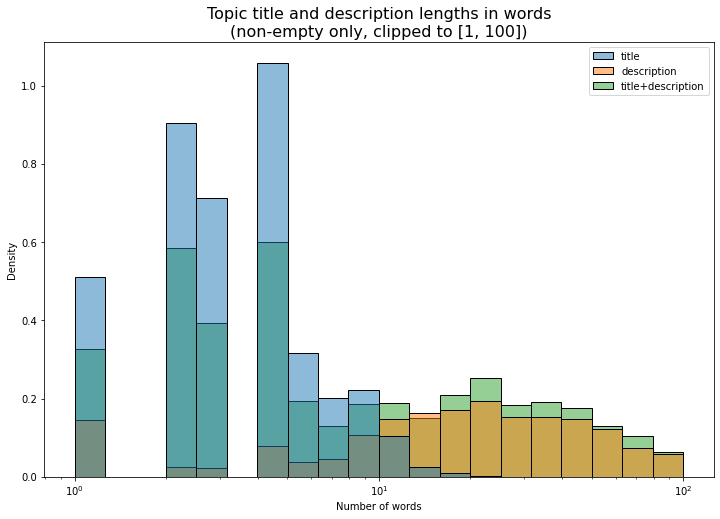

titles:
- 2 (0.00%) are empty
- 0 (0.00%) are above 100 words
descriptions:
- 42022 (54.59%) are empty
- 890 (1.16%) are above 100 words


In [12]:
# Distributions of title and description lengths in words
def plot_text_len(text_df, title, clip=100):
    text_len = text_df.applymap(lambda x: len(x.strip().split()))
    n_empty = (text_len == 0).sum()
    n_clipped = (text_len > clip).sum()
    text_len['+'.join(text_len.columns.values)] = text_len.sum(axis=1)

    clipped_len = np.clip(text_len.replace(0, np.nan), 1, clip) # exclude empty
    sns.histplot(clipped_len, stat='density', log_scale=True, binwidth=0.1)
    plt.title(f'{title}\n(non-empty only, clipped to [1, {clip}])', fontsize=16)
    plt.xlabel('Number of words')
    plt.show()
    for cat in n_empty.index:
        print(f'{cat}s:\n- {n_empty[cat]} ({100*n_empty[cat]/len(text_len):.2f}%) are empty'\
              f'\n- {n_clipped[cat]} ({100*n_clipped[cat]/len(text_len):.2f}%) are above {clip} words')
    return

plot_text_len(topics_df[['title', 'description']], 'Topic title and description lengths in words')

- Half the topics have descriptions
- Almost all topic titles + descriptions are under 100 words --- could use directly with transformers (due to O(N^2) complexity)
- If cross-topic features used, should try a summarizer / reduction algorithm before any transformer

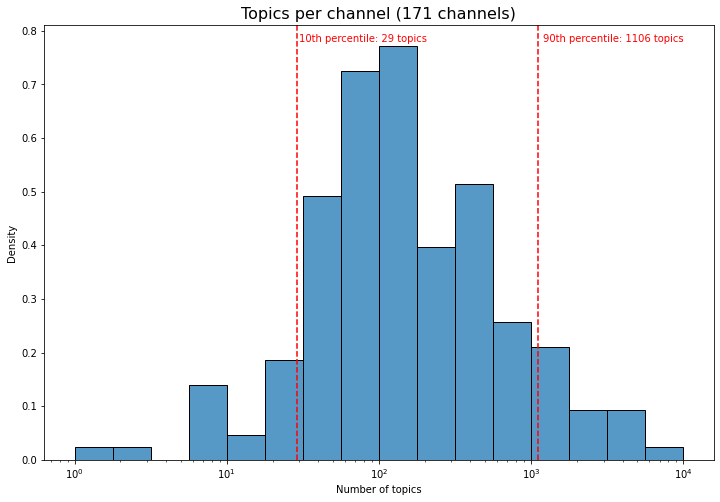

In [13]:
# Distribution of number of topics per channel (tree branches)
n_topics_per_channel = topics_df.groupby('channel').size()
q10 = int(np.percentile(n_topics_per_channel, 10))
q90 = int(np.percentile(n_topics_per_channel, 90))

sns.histplot(n_topics_per_channel, stat='density', binwidth=0.25, log_scale=True)
plt.axvline(q10, color='red', linestyle='--')
plt.axvline(q90, color='red', linestyle='--')
plt.text(q10 + 1, 0.78, f'10th percentile: {q10} topics', color='red')
plt.text(q90 + 100, 0.78, f'90th percentile: {q90} topics', color='red')

plt.title(f'Topics per channel ({n_topics_per_channel.size} channels)', fontsize=16)
plt.xlabel('Number of topics')
plt.show()

- 171 channels / topic trees in data
- Most channels contain 10s--1000 topics --- will need a constrained tree search if using cross-topic features; consider relative positional encodings

In [14]:
# Get number of content items per channel (tree leaves)
# n_content_per_channel = pd.Series([len(Topic(topic_id).subtree_content) for topic_id in root_topics.index], index=root_topics.channel)
# n_content_per_channel.to_csv(CACHE_DIR/'n_content_per_channel.csv')
n_content_per_channel = pd.read_csv(CACHE_DIR/'n_content_per_channel.csv', index_col=0, squeeze=True)

In [ ]:
# Print topic tree for a random channel (limit content items)
def print_topic_tree(topic, depth=0):
    print(f'{"   "*depth+"|--"}{topic.title}')
    for child in topic.children:
        print_topic_tree(child, depth=depth + 1)
    for content in topic.content:
        print(f'{"   "*(depth + 1)+"|--"}{content.title}')
        
def print_rand_topic_tree(max_content=50):
    rand_channel = n_content_per_channel[n_content_per_channel <= max_content].sample(1).index[0]
    rand_topic = Topic(root_topics[root_topics == rand_channel].index[0])
    print_topic_tree(rand_topic)
    
print_rand_topic_tree()

- Titles, descriptions and texts in topics and contents contain starting and trailing whitespace / line breaks --- will want to remove this.

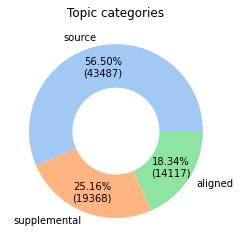

In [16]:
# Distribution of topic categories
def plot_pie_chart(counts, title=''):
    colors = sns.color_palette('pastel')[:counts.shape[0]]
    fig = plt.figure(figsize=(4, 4))
    plt.title(title, fontsize=12)
    p, tx, autotexts = plt.pie(counts, labels=counts.index, autopct='', colors=colors, pctdistance=0.75)
    white_center = plt.Circle((0, 0), 0.50, fc='white')
    fig.gca().add_artist(white_center)
    for i, a in enumerate(autotexts):
        a.set_text(f'{100*counts[i]/len(topics_df):.2f}%\n({counts[i]})')
    plt.show()
    return

plot_pie_chart(topics_df['category'].value_counts(), 'Topic categories')

- Test data contains only 'aligned' and 'supplemental' categories (about 50/50), Ref. [1] --- optimize performance mostly on these and ensure validation only on these.
- Training data contains a majority of 'source' topics --- consider whether to fine-tune with these.

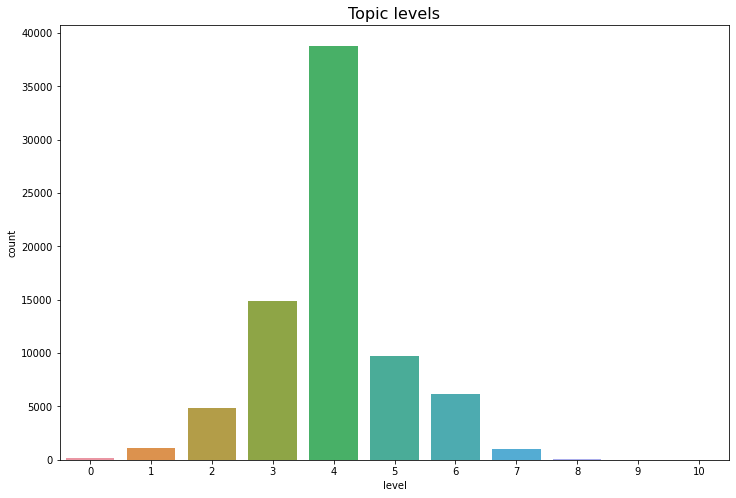

In [17]:
# Distribution of topic levels
sns.countplot(x=topics_df['level'])
plt.title('Topic levels', fontsize=16)
plt.show()

- Expect level to correlate somewhat with vocabulary level used in topic texts and corresponding contents

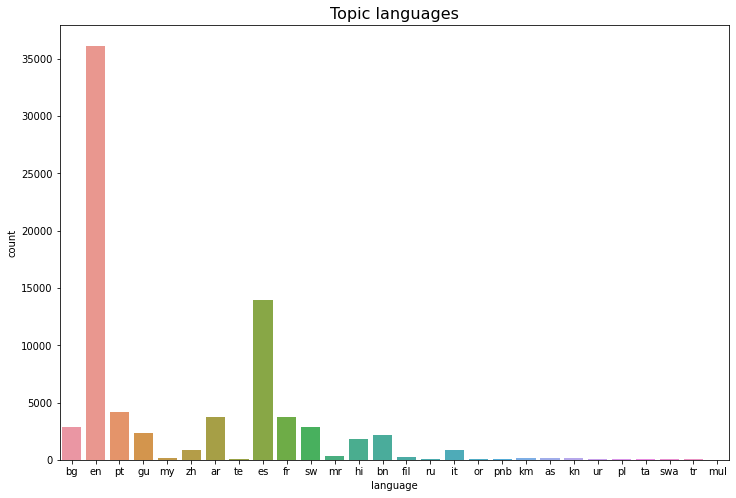

In [18]:
# Distribution of topic languages
sns.countplot(x=topics_df['language']) #TODO: sort by count
plt.title('Topic languages', fontsize=16)
plt.show()

In [19]:
# Percentage of topics whose content matches in language, copied from Ref. [2]
matching = 0
nonmatching = 0
for topic_id in topics_df.query('has_content').sample(n=1000).index:
    topic = Topic(topic_id)
    if any(topic.language != content.language for content in topic.content):
        nonmatching += 1
    else:
        matching += 1
        
print(f'Percentage of topics matching all their content in language: {(100*matching / (matching+nonmatching)):.2f}% ({matching}/{matching+nonmatching} sampled)')

Percentage of topics matching all their content in language: 99.40% (994/1000 sampled)


- Topics and content mostly in English and Spanish (some Portuguese, Arabic, French, etc.)
- Need multi-lingual LM with > NUM_LANGUAGES #TODO: get no. languages

In [20]:
# Percentage of topics with content
print(f'Percentage of topics with content: {topics_df["has_content"].mean()*100:.2f}%')

Percentage of topics with content: 79.92%


- 20% of topics are branches without content explicitly categorized at their tree level

### Exploring content

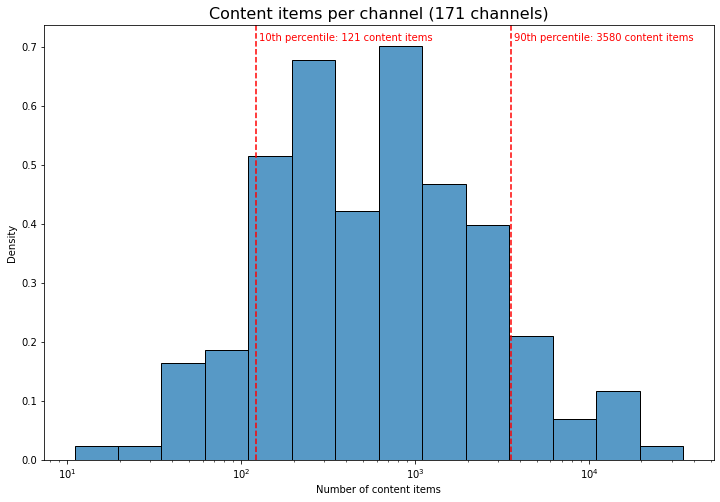

In [21]:
# Distribution of number of content items per channel (tree leaves)
q10 = int(np.percentile(n_content_per_channel, 10))
q90 = int(np.percentile(n_content_per_channel, 90))

sns.histplot(n_content_per_channel, stat='density', binwidth=0.25, log_scale=True)
plt.axvline(q10, color='red', linestyle='--')
plt.axvline(q90, color='red', linestyle='--')
plt.text(q10 + 5, 0.71, f'10th percentile: {q10} content items', color='red')
plt.text(q90 + 100, 0.71, f'90th percentile: {q90} content items', color='red')

plt.title(f'Content items per channel ({n_topics_per_channel.size} channels)', fontsize=16)
plt.xlabel('Number of content items')
plt.show()

- Most channels contain 100--1000s content items

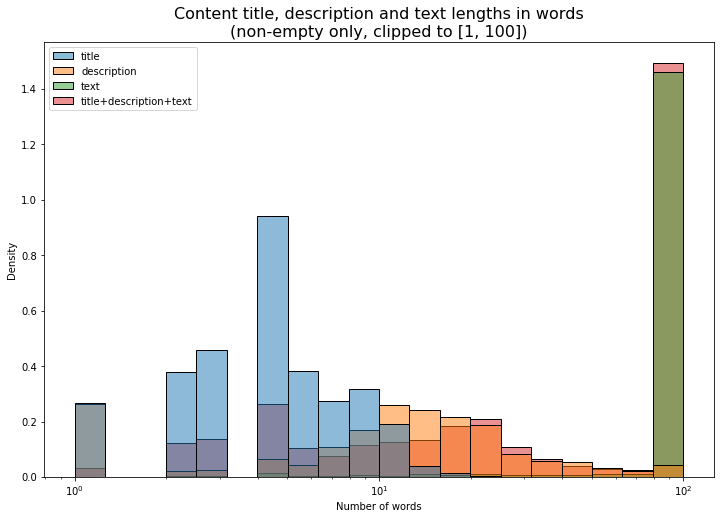

titles:
- 9 (0.01%) are empty
- 0 (0.00%) are above 100 words
descriptions:
- 64655 (41.97%) are empty
- 1507 (0.98%) are above 100 words
texts:
- 80012 (51.94%) are empty
- 67885 (44.07%) are above 100 words


In [22]:
# Distributions of title, description and text lengths in words
plot_text_len(content_df[['title', 'description', 'text']], 'Content title, description and text lengths in words')

- Content title and description lengths have similar distributions to topics
- Many long content texts --- should consider summarizing if used

### Exploring correlations

In [23]:
# Store correlations as exploded Series with repeated topic indices
correlations = correlations_df.squeeze().explode()

# Get average no. content items per topic
n_content_per_topic = correlations_df.applymap(len)

In [24]:
# Check that no. topics with content and no. topics in correlation matrix match
print(f"Topics with content: {len(topics_df.loc[topics_df['has_content']==True].index)}")
print(f"Rows in correlation matrix: {len(correlations_df.index)}")

Topics with content: 61517
Rows in correlation matrix: 61517


In [25]:
# Print other statistics
print(f'Average number of correlations per topic: {n_content_per_topic.mean()[0]:.1f}')
print(f'No. correlations: {correlations.size} (with {correlations.unique().size} unique content items, ratio is {correlations.size/correlations.unique().size:.1f})')

# Check for empty entries
print(f"Number of empty entries in correlations: {((correlations_df == '') | (correlations_df.isna())).sum()[0]}")

# Check whether all content items appear in correlation matrix
print(f'All contents are correlated to topics: {set(correlations) == set(content_df.index)}')

Average number of correlations per topic: 4.6
No. correlations: 279919 (with 154047 unique content items, ratio is 1.8)
Number of empty entries in correlations: 0
All contents are correlated to topics: True


- The correlation mapping, f : Topic -> Content(s), is surjective (all contents get mapped to), but not injective (the same content can correlate to multiple topics)
- On average, a given content is correlated to ~1.8 topics, while a given topic is correlated to ~4.6 contents

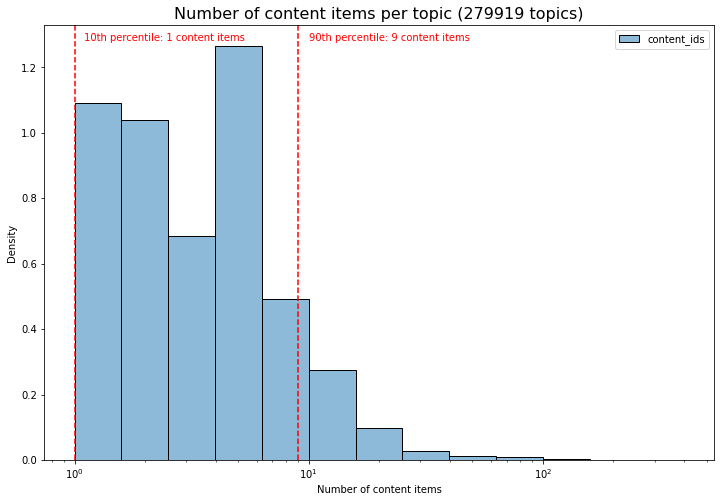

min: 1, max: 293


In [26]:
# Full distribution of number of content items per topic
q10 = int(np.percentile(n_content_per_topic, 10))
q90 = int(np.percentile(n_content_per_topic, 90))

sns.histplot(n_content_per_topic, stat='density', binwidth=0.2, log_scale=True)
plt.axvline(q10, color='red', linestyle='--')
plt.axvline(q90, color='red', linestyle='--')
plt.text(q10 + 0.1, 1.28, f'10th percentile: {q10} content items', color='red')
plt.text(q90 + 1, 1.28, f'90th percentile: {q90} content items', color='red')

plt.title(f'Number of content items per topic ({correlations.size} topics)', fontsize=16)
plt.xlabel('Number of content items')
plt.show()

print(f'min: {n_content_per_topic.min()[0]}, max: {n_content_per_topic.max()[0]}')

- Most topics have < 10 correlations, but some have 10--300 --- will need candidate pool of at least 300 (although performance evaluated by F2 mean across samples)